In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
from settings import *
from utils import get_bill, eval_annual
from battery import Battery

#### 1. Read building net load data

In [2]:
PATH_DATA = 'data/load.xlsx'
load_org = pd.read_excel(PATH_DATA) # Original load
# Convert load data to a structure (month, hour)
load_org = np.array(load_org).reshape((720, 12), order='F') # 720 hours per month for 12 months
load_org = load_org.transpose()

#### 2. Select dispatch method, degradation model, and pricing plan

In [3]:
dispatch_method = "constant_peak"
degModel = "Xu"
pricing_plan = "flat"

#### 3. Select initial round-trip efficiency, SoC, and desired range of energy and power capacities

In [4]:
eff = 0.95
soc_ini = 0.5
    
dE = 10
dP = 10
Emaxs = np.arange(dE, 100, dE)
Pmaxs = np.arange(dP, 100, dP)

#### 4. For each combination of Emax and Pmax, perform lifetime evaluation

In [5]:
NPVs = np.zeros((len(Emaxs), len(Pmaxs)))

for i in range(len(Emaxs)):
    Emax = Emaxs[i]
    Emin = 0
    for j in range(len(Pmaxs)):
        Pmax = Pmaxs[j]
        Pmin = -Pmax
            
        NPV = -(cost_capacity*Emax + cost_power_equip*Pmax + cost_construction*Pmax)
        battery = Battery(Emax=Emax, Emin=Emin, Pmax=Pmax, Pmin=Pmin,\
                          eff=eff, soc_ini=soc_ini, degModel=degModel)
        
        # Lifetime evaluation
        for n in range(Nyear):
            # Annual evaluation
            saving, load_new, Es, cs, ds = eval_annual(load_org, battery,\
                                                       method=dispatch_method,\
                                                       pricing_plan=pricing_plan)
            NPV += saving/(1+ir)**(n+1)
            Es = Es.ravel(order='C')
            cs = cs.ravel(order='C')
            ds = ds.ravel(order='C')
            xs = cs - ds
            battery.degradate(degEff=degEff, Es=Es, xs=xs)
            
        NPVs[i,j] = NPV
        print(Emax, Pmax, NPV, 'New case added')
        
res = {'Emaxs': Emaxs, 'Pmaxs': Pmaxs, 'NPVs': NPVs}
save_obj(res, f'results/{dispatch_method}-{degModel}-{pricing_plan}')

10 10 24897.77068565046 New case added
10 20 22897.77068565046 New case added
10 30 20897.77068565046 New case added
10 40 18897.770685650463 New case added
10 50 16897.770685650463 New case added
10 60 14897.770685650465 New case added
10 70 12897.770685650465 New case added
10 80 10897.770685650465 New case added
10 90 8897.770685650463 New case added
20 10 39462.48649062998 New case added
20 20 46138.0982594993 New case added
20 30 44138.0982594993 New case added
20 40 42138.0982594993 New case added
20 50 40138.0982594993 New case added
20 60 38138.0982594993 New case added
20 70 36138.0982594993 New case added
20 80 34138.09825949929 New case added
20 90 32138.098259499293 New case added
30 10 42281.32104552812 New case added
30 20 55105.29290557544 New case added
30 30 53212.90719585401 New case added
30 40 51212.90719585401 New case added
30 50 49212.90719585401 New case added
30 60 47212.90719585401 New case added
30 70 45212.90719585401 New case added
30 80 43212.90719585402 N

#### 5. Visualize

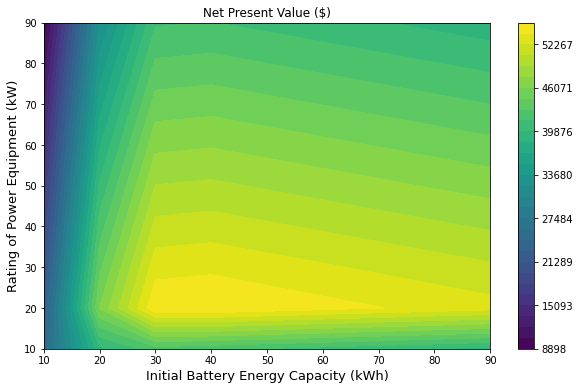

In [6]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)

X, Y = np.meshgrid(Emaxs, Pmaxs)
X = X.transpose()
Y = Y.transpose()
levels = np.linspace(NPVs.min(),NPVs.max(),31)
plot = ax.contourf(X, Y, NPVs, levels = levels)
fig.colorbar(plot)
ax.set_title('Net Present Value ($)')
ax.set_ylabel('Rating of Power Equipment (kW)', fontsize = 13)
ax.set_xlabel('Initial Battery Energy Capacity (kWh)', fontsize = 13)
fig.savefig(f"imgs/{dispatch_method}-{degModel}-{pricing_plan}.png")